DATASET:  archivo cvs –Tuberculosis incidence (per 100,000 people) 

Usando un algoritmo similar al presentado en clase y en la práctica, realizar un programa en Python que determine los clústers en los datos del archivo cvs según 3 variables.  
 
1) Explique si tuvo que realizar algún tipo de pre-procesamiento en los archivos cvs. 
 
2) Explique la técnica utilizada para establecer el número de clústers para cada archivo. Justifique su respuesta. 
 
3) Basado en los clústers establecidos, determinar en cuántos conjuntos se agrupan los datos similares de los diferentes países y qué características son más representativas para cada grupo, realizando la mayor caracterización de los datos posible.  
 
Para este ejercicio se usarán un dataset: Tuberculosis incidence (per 100,000 people) 
 
NOTA: Recuerde explicar qué está haciendo en cada parte del código. Para esto debe entregar el Worksheet correspondiente, debidamente documentado. 
 
4) A partir del análisis de resultados describa 5 tendencias encontradas en los datos, justifique su respuesta. 
 
5) ¿Qué puede concluir del porcentaje de tuberculosis en latinoamérica? ¿Qué países tienen los peores índices y en cual clúster quedaron? (cite un país en cada continente).


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
pd.set_option("max_columns",2000)
pd.set_option("max_rows",2000)

import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 5)
plt.style.use('ggplot')


In [2]:
df=pd.read_csv("tuberculosis.csv")
df.head()


,,,,,,,,,,,,,,,,,,,,,"Tuberculosis incidence (per 100,000 people)"
HDI Rank (2018),Country,2000,NaN,2005,NaN,2010,NaN,2011,NaN,2012,NaN,2013,NaN,2014,NaN,2015,NaN,2016,NaN,2017,NaN
170,Afghanistan,190.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN
69,Albania,22.0,NaN,19.0,NaN,17.0,NaN,17.0,NaN,16.0,NaN,19.0,NaN,16.0,NaN,16.0,NaN,16.0,NaN,20.0,NaN
82,Algeria,74.0,NaN,80.0,NaN,77.0,NaN,73.0,NaN,73.0,NaN,67.0,NaN,72.0,NaN,74.0,NaN,70.0,NaN,70.0,NaN
36,Andorra,21.0,NaN,15.0,NaN,9.5,NaN,4.1,NaN,13.0,NaN,7.1,NaN,8.7,NaN,5.9,NaN,6.0,NaN,1.5,NaN


## <font color='red'>Observaciones: </font> 
### Se puede observar que de entrada hay algo extraño en el dataset, pues al leerlo como se acostumbra, se evidencia que los nombres de las columnas no están quedando en la posición que debería. Se debe tocar el parametro header en la lectura del dataframe, se debe asígnar a uno, que es el número de fila donde están los nombres de las columnas.

In [3]:
df=pd.read_csv("tuberculosis.csv", delimiter=",", header=1)
df[0:]
##Tuberculosis incidence (per 100,000 people)

,HDI Rank (2018),Country,2000,Unnamed: 3,2005,Unnamed: 5,2010,Unnamed: 7,2011,Unnamed: 9,2012,Unnamed: 11,2013,Unnamed: 13,2014,Unnamed: 15,2015,Unnamed: 17,2016,Unnamed: 19,2017,Unnamed: 21
0,170,Afghanistan,190.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN,189.0,NaN
1,69,Albania,22.0,NaN,19.0,NaN,17.0,NaN,17.0,NaN,16.0,NaN,19.0,NaN,16.0,NaN,16.0,NaN,16.0,NaN,20.0,NaN
2,82,Algeria,74.0,NaN,80.0,NaN,77.0,NaN,73.0,NaN,73.0,NaN,67.0,NaN,72.0,NaN,74.0,NaN,70.0,NaN,70.0,NaN
3,36,Andorra,21.0,NaN,15.0,NaN,9.5,NaN,4.1,NaN,13.0,NaN,7.1,NaN,8.7,NaN,5.9,NaN,6.0,NaN,1.5,NaN
4,149,Angola,297.0,NaN,368.0,NaN,384.0,NaN,383.0,NaN,380.0,NaN,376.0,NaN,370.0,NaN,366.0,NaN,362.0,NaN,359.0,NaN
5,74,Antigua and Barbuda,5.5,NaN,7.7,NaN,8.5,NaN,7.2,NaN,3.6,NaN,12.0,NaN,3.5,NaN,4.4,NaN,3.4,NaN,1.1,NaN
6,48,Argentina,37.0,NaN,31.0,NaN,20.0,NaN,27.0,NaN,24.0,NaN,24.0,NaN,25.0,NaN,25.0,NaN,27.0,NaN,26.0,NaN
7,81,Armenia,54.0,NaN,92.0,NaN,61.0,NaN,55.0,NaN,53.0,NaN,60.0,NaN,57.0,NaN,50.0,NaN,44.0,NaN,36.0,NaN
8,6,Australia,6.3,NaN,5.9,NaN,6.5,NaN,6.3,NaN,6.6,NaN,6.2,NaN,6.5,NaN,6.1,NaN,6.6,NaN,6.8,NaN
9,20,Austria,17.0,NaN,13.0,NaN,9.1,NaN,9.1,NaN,8.4,NaN,8.4,NaN,7.5,NaN,7.5,NaN,8.2,NaN,7.4,NaN


### De entrada se notan varios errores en el dataset. Hay muchas columnas unnamed, las cuales están llenas de valores NaN. Se inspeccionó manualemente el archivo .csv y lo qué pasa es: 
 ### Primera fila:  
 #### HDI Rank (2018),"Country","2000","","2005","","2010","","2011","","2012","","2013","","2014","","2015","","2016","","2017",""
 
 ### Fila cualquiera:
 #### 170,"Afghanistan","190.0","","189.0","","189.0","","189.0","","189.0","","189.0","","189.0","","189.0","","189.0","","189.0",""
 
 ### Lo que significa que estan quedando unos espacios en blanco, en los cuales no hay dato presente, en absolutamente ninguna columna de las llamadas unnamed: x, prueba de ello:

In [4]:
df["Unnamed: 3"].value_counts() ##Todos los datos vacios.

Series([], Name: Unnamed: 3, dtype: int64)

### Una acción a seguir podría ser eliminar dichas colummnas unnamed, pero como a fin de cuentas solo se deben seleccionar 3 columnas (que evidentemente no serán estas) para la clusterización, automaticamente se eliminarán cuando se filtre el dataset.

 ## <font color='red'><h1>Entendiendo los datos: </h1></font> 
### El paso siguiente será identificar a qué dato corresponde cada columna. Qué significa cada una? Se debe tener en cuenta siempre, que entender los datos, su relevancia, relación y significado, es uno de los procesos vitales dentro de la ciencia de datos.

### En la data proporcionada por el profesor, no se evidencia y cuenta clamente a qué corresponde cada columna, por lo que se examina en internet, fuente: https://data.worldbank.org/indicator/SH.TBS.INCD

### El valor presente en la columna de cada año, corresponde entonces a: 
### La incidencia de tuberculosis es el número estimado de casos nuevos y recurrentes de tuberculosis que surgen en un año determinado, expresados como la tasa por 100,000 habitantes. En otras palabras, es una estimación de cuantos casos aparecerán en un año, por cada 100000 habitantes


### Se observa que el análisis del dataset, en general está presentado como datos por paises. Pero al final se notan algunos registros que no pertenecen a países, pertenecen a regiones:


In [5]:
df[196:] ## últimas filas qué representan? Son regiones, por qué? Son consolidados por regiones, o sea que estos tienen
##agrupaciones de países.

,HDI Rank (2018),Country,2000,Unnamed: 3,2005,Unnamed: 5,2010,Unnamed: 7,2011,Unnamed: 9,2012,Unnamed: 11,2013,Unnamed: 13,2014,Unnamed: 15,2015,Unnamed: 17,2016,Unnamed: 19,2017,Unnamed: 21
196,,Very high human development,32.9,NaN,30.2,NaN,26.8,NaN,26.1,NaN,24.9,NaN,23.7,NaN,22.8,NaN,21.7,NaN,21.2,NaN,20.1,NaN
197,,High human development,144.0,NaN,138.5,NaN,127.5,NaN,126.3,NaN,124.4,NaN,121.3,NaN,119.4,NaN,116.9,NaN,112.9,NaN,111.3,NaN
198,,Medium human development,279.1,NaN,274.2,NaN,247.7,NaN,242.5,NaN,236.5,NaN,231.1,NaN,226.0,NaN,220.5,NaN,215.1,NaN,209.3,NaN
199,,Low human development,276.9,NaN,255.4,NaN,230.6,NaN,224.6,NaN,220.1,NaN,214.0,NaN,210.2,NaN,205.5,NaN,201.2,NaN,197.2,NaN
200,,Developing Countries,203.8,NaN,198.3,NaN,181.5,NaN,178.6,NaN,175.1,NaN,171.1,NaN,168.0,NaN,164.3,NaN,160.1,NaN,156.9,NaN
201,NaN,Regions,,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN
202,,Arab States,67.6,NaN,60.5,NaN,56.0,NaN,54.4,NaN,53.7,NaN,52.0,NaN,51.2,NaN,50.9,NaN,49.6,NaN,48.0,NaN
203,,East Asia and the Pacific,184.7,NaN,169.5,NaN,155.2,NaN,154.2,NaN,152.6,NaN,149.9,NaN,148.3,NaN,146.4,NaN,144.8,NaN,143.6,NaN
204,,Europe and Central Asia,93.3,NaN,94.0,NaN,76.1,NaN,73.2,NaN,68.2,NaN,64.4,NaN,60.9,NaN,57.2,NaN,54.4,NaN,52.1,NaN
205,,Latin America and the Caribbean,53.9,NaN,48.4,NaN,42.7,NaN,43.1,NaN,42.4,NaN,42.0,NaN,41.2,NaN,40.9,NaN,41.2,NaN,42.3,NaN


### Es natural preguntarse si los datos consolidados por regiones deberían tenerse en cuenta para la clusterización. Como respuesta, se sugiere preguntar, cualés son las respuestas qué busca el interesado? (en este caso Demetrio):
#### <font color='red'>  Basado en los clústers establecidos, determinar en cuántos conjuntos se agrupan los datos similares de los diferentes países y qué características son más representativas para cada grupo, realizando la mayor caracterización de los datos posible.
####  <font color='red'> ¿Qué puede concluir del porcentaje de tuberculosis en latinoamérica? ¿Qué países tienen los peores índices y en cual clúster quedaron? (cite un país en cada continente).  </font>
    
#### Según la información, sí parece importante conocer los resultados respecto a latinoamerica como grupo. Se excluyen entonces del análisis los otros grupos que no son relevantes dentro del cojunto de datos.

In [6]:
latinoamerica=df[df["Country"]=="Latin America and the Caribbean"] ##Se obtiene el registro de latinoamerica
datos=df[0:195] ##Obtengo los registro de solo paises.
datosfinales=pd.concat([datos,latinoamerica]) ##Uno ambos dataframes
datosfinales[194:] ##Se comprueba latinoamerica al final.

,HDI Rank (2018),Country,2000,Unnamed: 3,2005,Unnamed: 5,2010,Unnamed: 7,2011,Unnamed: 9,2012,Unnamed: 11,2013,Unnamed: 13,2014,Unnamed: 15,2015,Unnamed: 17,2016,Unnamed: 19,2017,Unnamed: 21
194,18,Liechtenstein,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN
205,,Latin America and the Caribbean,53.9,NaN,48.4,NaN,42.7,NaN,43.1,NaN,42.4,NaN,42.0,NaN,41.2,NaN,40.9,NaN,41.2,NaN,42.3,NaN


### <font color='red'>  <h1>Selección de variables: </h1> <font>

   ### Atendiendo la sugerencia del profesor, se decide hacer uso de 3 variables de año, separados lo más posible. Entonces se escoger analizar el dataset según año 2000,2010 y 2017.
   ### La variable HDI Rank (2018) debido a que representa una medida solo para el año 2018.

In [7]:
filtrado=datosfinales[["Country","2000","2010","2017"]]
filtrado.head()

,Country,2000,2010,2017
0,Afghanistan,190.0,189.0,189.0
1,Albania,22.0,17.0,20.0
2,Algeria,74.0,77.0,70.0
3,Andorra,21.0,9.5,1.5
4,Angola,297.0,384.0,359.0


### La variable country, se puede usar como el indice del dataFrame, ya que es única y es la mejor alternativa para representar todos los registros.

In [8]:
 ##Se asigna Country como el indice del dataframe
try: 
    filtrado=filtrado.set_index('Country')
except:
    pass
filtrado.head()

,2000,2010,2017
Country,,,
Afghanistan,190.0,189.0,189.0
Albania,22.0,17.0,20.0
Algeria,74.0,77.0,70.0
Andorra,21.0,9.5,1.5
Angola,297.0,384.0,359.0


#### <font color='red'>  <h1> Busqueda y correción de errores: </h1> <font>
    
### Se buscan posibles errores, NaN y faltantes dentro del conjunto de datos:

In [9]:
print(filtrado.describe()) ##Por qué no me arroja un resumen numeríco? Se sospecha de variable tipo object
print(filtrado.dtypes)
print(len(filtrado))

        2000  2010  2017
count    196   196   196
unique   143   151   147
top     22.0  28.0  12.0
freq       6     4     4
2000    object
2010    object
2017    object
dtype: object
196


### Se observa que al pedir la descripción del dataset, no muestra máximos y mínimos, lo que parecía indicar que las variables las estaba tomando como tipo object, y no tipo float. Lo anterior fue confirmado al hacer .dtypes y ver que el resultado son únicamente variables object. 
### Así mismo, aparentemente no hay presencia de datos faltantos o NaN, ya qye el count es 196
<br> 
### Se procede a hacer la correción del tipo de variable, pasandolas a tipo float:

In [10]:
try:
    filtrado.astype({'2010': 'float64'}).dtypes
except:
    print("hubo error en 2010")
try:
    filtrado.astype({'2000': 'float64'}).dtypes
except:
    print("hubo error en 2000")
try:
    filtrado.astype({'2017': 'float64'}).dtypes
except:
    print("hubo error en 2017")
    

hubo error en 2010
hubo error en 2000
hubo error en 2017


### Error, al parecer el casteo no se puede hacer directamente, debido a que hay presencia de string en las columnas. Es necesario averiguar a que corresponden estos strings. 
### Se trata de buscar primero se corresponden a campos " ", NaN o vacios, tratando de buscar nulos:

In [11]:
filtrado[filtrado.isnull().any(axis=1)]

,2000,2010,2017
Country,,,


### No se encontraron valores nulos en el dataset, por lo que es necesario ir a mirar más en el fondo que es lo que está pasando con los strings que estén presentes:


In [12]:
filtrado[0:]

,2000,2010,2017
Country,,,
Afghanistan,190.0,189.0,189.0
Albania,22.0,17.0,20.0
Algeria,74.0,77.0,70.0
Andorra,21.0,9.5,1.5
Angola,297.0,384.0,359.0
Antigua and Barbuda,5.5,8.5,1.1
Argentina,37.0,20.0,26.0
Armenia,54.0,61.0,36.0
Australia,6.3,6.5,6.8


### Se encontró que algunos valores están de la forma "...", que es un null, que no reconoce pandas por defecto. Se va a proceder a cambiar dichos valores por NaN, para que pandas los reconozca como null.

In [13]:
for columna in filtrado.columns:  ##CICLO PARA CAMBIAR TODOS LOS VALORES ... A  VACIOS
    for registro in filtrado.index:
        if filtrado.loc[registro][columna]=="..":
            filtrado.at[registro,columna]=np.nan
            
filtrado[0:]  ##listo, ningun ".."        

,2000,2010,2017
Country,,,
Afghanistan,190.0,189.0,189.0
Albania,22.0,17.0,20.0
Algeria,74.0,77.0,70.0
Andorra,21.0,9.5,1.5
Angola,297.0,384.0,359.0
Antigua and Barbuda,5.5,8.5,1.1
Argentina,37.0,20.0,26.0
Armenia,54.0,61.0,36.0
Australia,6.3,6.5,6.8


In [14]:
filtrado[filtrado.isnull().any(axis=1)] ##Chequenado los nulos nuevamente:

,2000,2010,2017
Country,,,
Montenegro,NaN,20.0,14.0
Serbia,NaN,30.0,19.0
South Sudan,NaN,NaN,146.0
Timor-Leste,NaN,498.0,498.0
Liechtenstein,NaN,NaN,NaN


### Qué manejo se le puede dar a dichos valores NaN? En este caso, como se identificaron claramente las filas que contienen un NaN, y son pocas, se puede proceder manualmente. Se tómo la siguiente determinación, para las filas que tengan 2 o más NaN en sus columnas, se eliminará el registro del dataset. Los que tengan un solo NaN, se podría usar el valor que posea el grupo al cual pertenece, tomando el valor del dataset inicial. Por ejemplo, en el caso de Serbia, que en 2000 tiene un NaN, sabemos que pertenece a Europa, se puede buscar allá en el dataset inicial el valor de europa para dicho año, y se le asigna a Serbia. Este método parece mejor que imputar NaN con la media, ya que podría sesgarsen los datos.<br>
### Con esto, lo primero entonces es borrar los registros de South Sudan y Liechtenstein	

In [15]:
try:
    filtrado = filtrado.drop('South Sudan')
    filtrado = filtrado.drop('Liechtenstein')
except:
    pass
filtrado[filtrado.isnull().any(axis=1)] ##Chequenado los nulos nuevamente:

,2000,2010,2017
Country,,,
Montenegro,NaN,20.0,14.0
Serbia,NaN,30.0,19.0
Timor-Leste,NaN,498.0,498.0


### Para tratar con los valores faltantes del año 2000, se usa entonces los grupos correspondientes en el dataframe inicial:
    
#### * Serbia y montenegro pertenecen a Europa, por lo que se puede tomar el grupo Europe and Central Asia del datataframe inicial. <br>
#### * Timor-Leste está ubicado en el sudeste Asiático https://es.wikipedia.org/wiki/Timor_Oriental por lo que se puede tomar e el grupo South Asia del dataframe inicial.

In [16]:
valoreuropa=df.loc[204]["2000"] #tomo valores del dataset inicial
valorasia=df.loc[206]["2000"]
##print(valoreuropa,valorasia)
filtrado.at["Montenegro","2000"]=valoreuropa
filtrado.at["Serbia","2000"]=valoreuropa
filtrado.at["Timor-Leste","2000"]=valorasia
filtrado[filtrado.isnull().any(axis=1)] ##Chequenado los nulos nuevamente:

,2000,2010,2017
Country,,,


### Finalmente se pueden convertir las columnas a tipo float, para tener consistencia:

In [17]:
datafinal= filtrado.apply(pd.to_numeric, errors='coerce')
datafinal.describe()

,2000,2010,2017
count,194.000000,194.000000,194.000000
mean,149.448969,134.542268,109.336598
std,195.407064,188.260003,141.252788
min,0.000000,0.000000,0.000000
25%,22.000000,16.250000,12.000000
50%,69.000000,52.500000,46.000000
75%,218.250000,174.250000,152.000000
max,1070.000000,1120.000000,665.000000


### Se observa que los datos son tomados como numéricos sin ningún problema y se pueden hacer análisis descriptivos básicos:

###  * Por ejemplo, se puede ver como a nivel mundial, con el paso del tiempo la media de la incidencia de casos tuberculosis por cada 100.000 personas, ha ido bajando a lo largo del tiempo. Esto obviamente puede deberse a los avances medicos que han habido durante todo ese tiempo, así como al avance de la cobertura misma.

###  * Llama la atención el hecho de que en 2010 el valor máximo haya superado el valor máximo del 2000, cuando se supone que debería haber sido mejor.


### Teniendo un dataset bien codificado, limpio de errores o NaN, está listo para ser procesado en la clusterización.

### Se observan los histogramas de los datos:


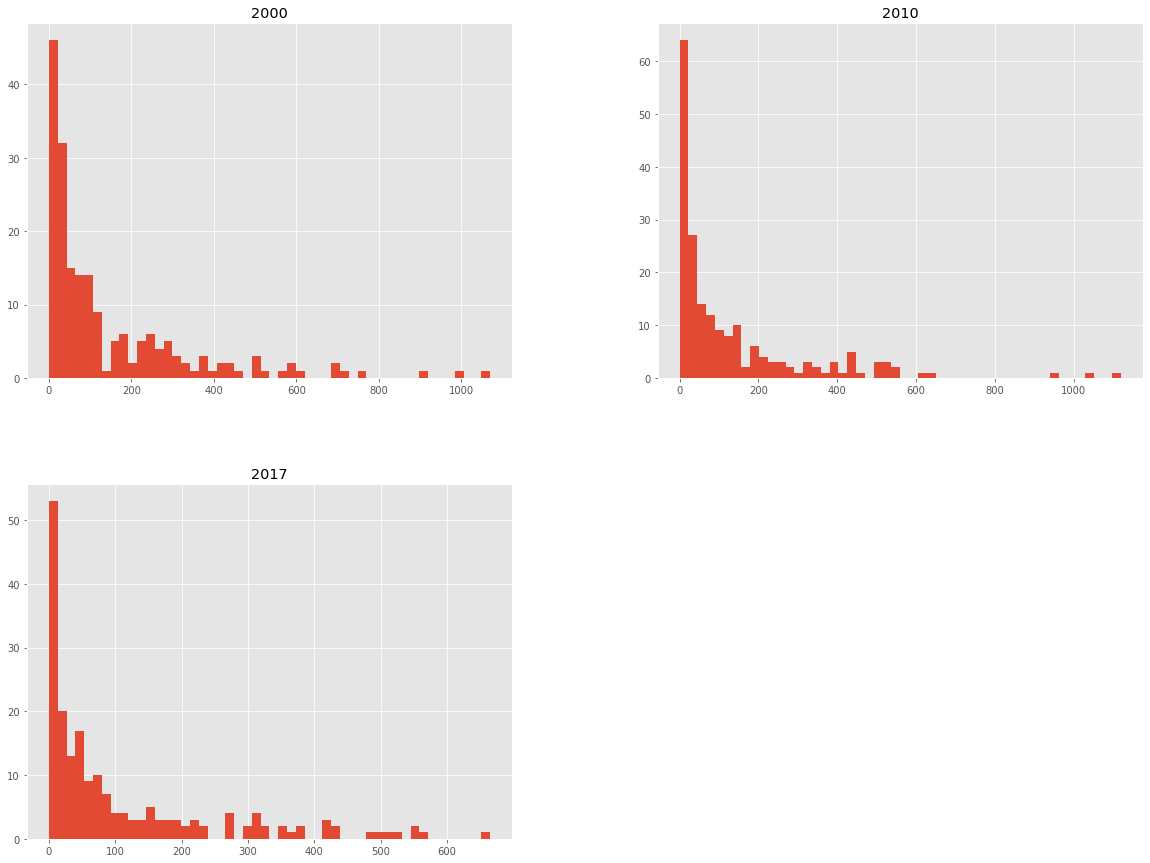

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt 
datafinal.hist(bins=50, figsize=(20,15))
plt.show()

### Es llamativo observar que en ambas variables los valores se concentran mayormente por debajo de un indice de 200. Qué hay después de 200?


In [19]:
datafinal[datafinal["2000"]>200]
datafinal[(datafinal['2000'] >200) & (datafinal['2010']>200 ) & (datafinal['2017']>200 )]

,2000,2010,2017
Country,,,
Angola,297.0,384.0,359.0
Bangladesh,221.0,221.0,221.0
Botswana,914.0,518.0,300.0
Cambodia,575.0,436.0,326.0
Central African Republic,1070.0,431.0,423.0
Congo,356.0,386.0,376.0
Congo (Democratic Republic of the),327.0,327.0,322.0
Djibouti,692.0,613.0,269.0
Eswatini (Kingdom of),692.0,1050.0,308.0


### Se evidencia que dichos valores generalmente se reportan en países de escasos recursos, como se puede ver en el filtro anterior, que la mayoría son países Áfricanos.

### Los histogramas de las 3 variables lucen similares en muchas partes, aunque a diferente escala. Se podría observar algún grado de correlación entre las variables:

C:\Users\Gonza\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


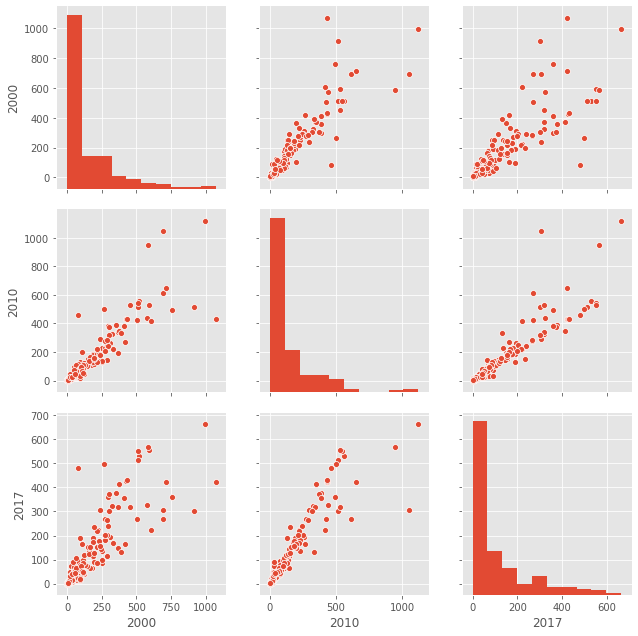

In [20]:
import seaborn as sb
sb.pairplot(datafinal,size=3,vars=["2000","2010","2017"],kind='scatter') ##Grafica con base en 3 variables.

### Visualemente sí parece haber alta correlación entre las variables, lo cúal podría no ser tan bueno para el modelo. Se busca la correlación de Pearson para tener datos más cuantitativos:

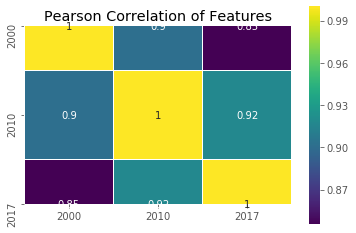

In [21]:
colormap = plt.cm.viridis  #Correlación de Pearson
#plt.figure(figsize=(13,13))
plt.title('Pearson Correlation of Features')
sb.heatmap(datafinal.corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)


##DEMASIADA CORRELACIÓN

### Se comprueba la sospecha que se tenía desde la grafica y se nota que las variables están altamente correlacionadas. Al no tener más posibilidades de información, se procede a trabajar con la alta correlación, teniendo muy presente que esto podría afectar un poco el modelo final

#### <font color='red'>  <h1> ESCALAR LOS DATOS: </h1> <font>
    


In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataescalada=datafinal.copy()
dataescalada[dataescalada.columns] = scaler.fit_transform(dataescalada[dataescalada.columns])
dataescalada.head()

,2000,2010,2017
Country,,,
Afghanistan,0.177570,0.168750,0.284211
Albania,0.020561,0.015179,0.030075
Algeria,0.069159,0.068750,0.105263
Andorra,0.019626,0.008482,0.002256
Angola,0.277570,0.342857,0.539850


#### <font color='red'>  <h1> Buscando el número de clusters: </h1> <font>
    
### Se usa el método del codo para buscar el número de clusters óptimo. Acá se selecciona el número K en el que se evidencie que empiezan cambios poco significativos en la variación de las pendientes en la curva. Para esto, se entrenan kmeans desde 2 hasta 10 clusters.

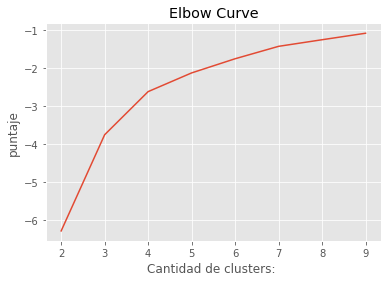

In [23]:
Nc = range(2, 10) ##De 2 a 10
kmeans = [KMeans(n_clusters=i) for i in Nc] ##Entrena ese número de modelos
#print(kmeans)
score = [kmeans[i].fit(dataescalada).score(dataescalada) for i in range(len(kmeans))] #Saca el puntaje
score
plt.plot(Nc,score) #Crea grafica
plt.xlabel('Cantidad de clusters: ')
plt.ylabel('puntaje') ##7 clusters
plt.title('Elbow Curve')
plt.show()

### Parece ser que el número óptimo de clusters se úbica en k=5. Se selecciona dicho K para la clusterización.
### Se procede a llamar el algoritmo k means, sobre los datos escalados

In [24]:
kmeans = KMeans(n_clusters=5).fit(dataescalada) ##Se llama Kmean con k=5
centroids = kmeans.cluster_centers_ ##Se obtienen los centroides
print(centroids)

[[0.03946501 0.0304851  0.04363626]
 [0.32747664 0.34255952 0.52715121]
 [0.70685358 0.92797619 0.77192982]
 [0.64037383 0.47232143 0.63894737]
 [0.21292835 0.15999504 0.22669173]]


### Se mapean los cluster para saber en qué cluster quedó cada país.

In [25]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = datafinal.index.values
cluster_map['cluster'] = kmeans.labels_
cluster_map.head(5)
kmeans.labels_

array([4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 0,
       3, 0, 0, 0, 0, 4, 4, 3, 4, 0, 3, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 4, 0, 3, 0, 0, 0, 0, 0, 4, 4, 0, 2, 4, 0, 0, 0, 3, 4, 4, 0, 4,
       0, 0, 0, 4, 1, 0, 4, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       1, 1, 3, 0, 0, 4, 4, 0, 0, 2, 1, 0, 0, 0, 4, 4, 0, 0, 0, 0, 1, 4,
       0, 0, 4, 0, 0, 1, 0, 0, 3, 1, 3, 0, 4, 0, 0, 0, 4, 4, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0,
       0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 4, 1, 4, 1, 0, 0, 0,
       0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 1, 0])

In [26]:
##Reconstrucción dataframe con cluster:
n=0
for i in datafinal.index:
    datafinal.at[i,"cluster"]=int(cluster_map.loc[n]["cluster"])
    n+=1

In [27]:
datafinal.head()

,2000,2010,2017,cluster
Country,,,,
Afghanistan,190.0,189.0,189.0,4.0
Albania,22.0,17.0,20.0,0.0
Algeria,74.0,77.0,70.0,0.0
Andorra,21.0,9.5,1.5,0.0
Angola,297.0,384.0,359.0,1.0


#### <font color='red'>  <h1>ANÁLISIS DE RESULTADOS: </h1> <font>

### Observemos el tamaño de cada uno de los cluster:

In [28]:
totales=datafinal["cluster"].value_counts()
#indices=datafinal["cluster"].value_counts().index
totales

0.0    127
4.0     36
1.0     18
3.0     10
2.0      3
Name: cluster, dtype: int64

### Se observa que hay dos extremos en tamaños de cluster:
  ### El cluster donde están la gran mayoría de países, el 0. -> 127 países
  ### El cluster donde hay una minoría muy marcada, el 2. ->3 países
  
### Análisis de clusters:

###   * Cluster 0, 127 paises

In [44]:
cluster0=datafinal[datafinal["cluster"]==0]
print(cluster0.index)
cluster0.describe()

Index(['Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       ...
       'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States',
       'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela (Bolivarian Republic of)', 'Yemen',
       'Latin America and the Caribbean'],
      dtype='object', name='Country', length=127)


,2000,2010,2017,cluster
count,127.000000,127.000000,127.000000,127.0
mean,42.227559,34.143307,29.018110,0.0
std,35.248795,30.963413,26.516321,0.0
min,0.000000,0.000000,0.000000,0.0
25%,12.500000,8.700000,7.250000,0.0
50%,32.000000,22.000000,19.000000,0.0
75%,65.500000,51.000000,44.500000,0.0
max,143.000000,119.000000,106.000000,0.0


#### * En dicho cluster 0, se tienen 127 países.
#### * Se caracteriza porque el valor medio de incidencia durante los tres años analizados es el más bajo de todos los cluster.
#### * Podría afirmarse que en este cluster están los países que tienen mejor accesp a salud en todo el mundo.
#### * Es el único cluster en el cual se presentan países con 0 de incidencia en todos los años analizados.
#### * Sus valores máximos están incluso lejanos que los valores mínimos de otros cluster
#### * Se puede ver en los histogramas que los valores se concentran mucho más en los índices más bajos de incidencia


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224F0916088>,
      dtype=object)

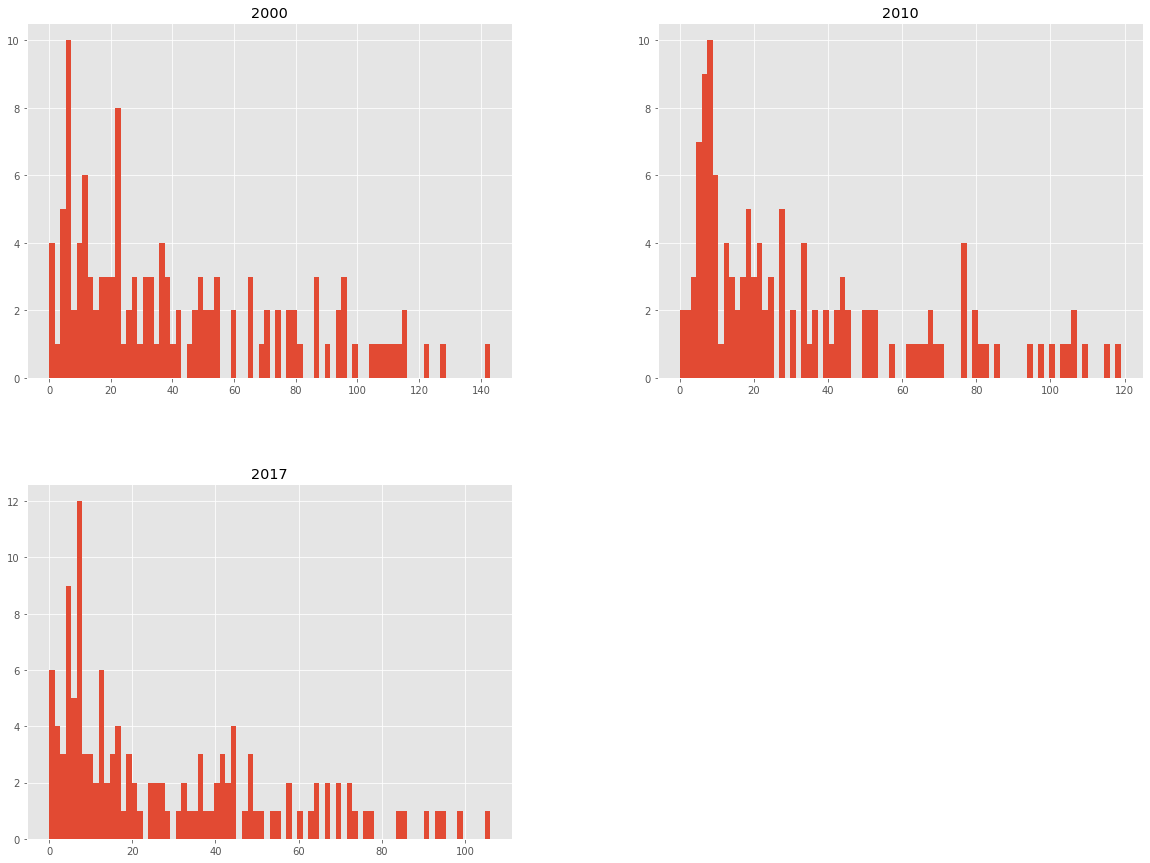

In [54]:
cluster0[["2000","2010","2017"]].hist(bins=80, figsize=(20,15))

### Cluster 1, 18 países

In [43]:
cluster1=datafinal[datafinal["cluster"]==1]
print(cluster1.index)
cluster1.describe()

Index(['Angola', 'Congo', 'Congo (Democratic Republic of the)',
       'Guinea-Bissau', 'Indonesia', 'Kenya', 'Kiribati', 'Liberia',
       'Marshall Islands', 'Mongolia', 'Myanmar', 'Pakistan',
       'Papua New Guinea', 'Sierra Leone', 'Somalia',
       'Tanzania (United Republic of)', 'Timor-Leste', 'Zimbabwe'],
      dtype='object', name='Country')


,2000,2010,2017,cluster
count,18.000000,18.000000,18.000000,18.0
mean,350.400000,383.666667,350.555556,1.0
std,115.136584,71.907620,77.075381,0.0
min,81.000000,276.000000,221.000000,1.0
25%,288.000000,330.750000,302.750000,1.0
50%,341.500000,384.000000,340.000000,1.0
75%,423.750000,427.500000,403.750000,1.0
max,605.000000,531.000000,498.000000,1.0


#### * En dicho cluster se ubicaron 18 países.
#### * Se caracteriza por ser países donde su valor medio de incidencia fue más elevado e incluso se intenta mantener en los años, está al rededor de 350-380
#### *Los valores máximos alcanzados en este cluster, son mucho mayores
#### *Evidentemente este cluster ha sido mucho más maltratado por la turberculosis, pero no llega a los niveles extremos que se tienen en otros cluster. Podría decirse que son países de afectación media alta, donde los casos en el histograma que se observan demasiado altos, son valores átipicos.
#### *Nuevamente se evidencia mayor presencia de países Áfricanos.

#### *Los histogramas muestran como la mayor cantidad de incidencias se concentran hacía la parte media del gráfico

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224F093ED48>,
      dtype=object)

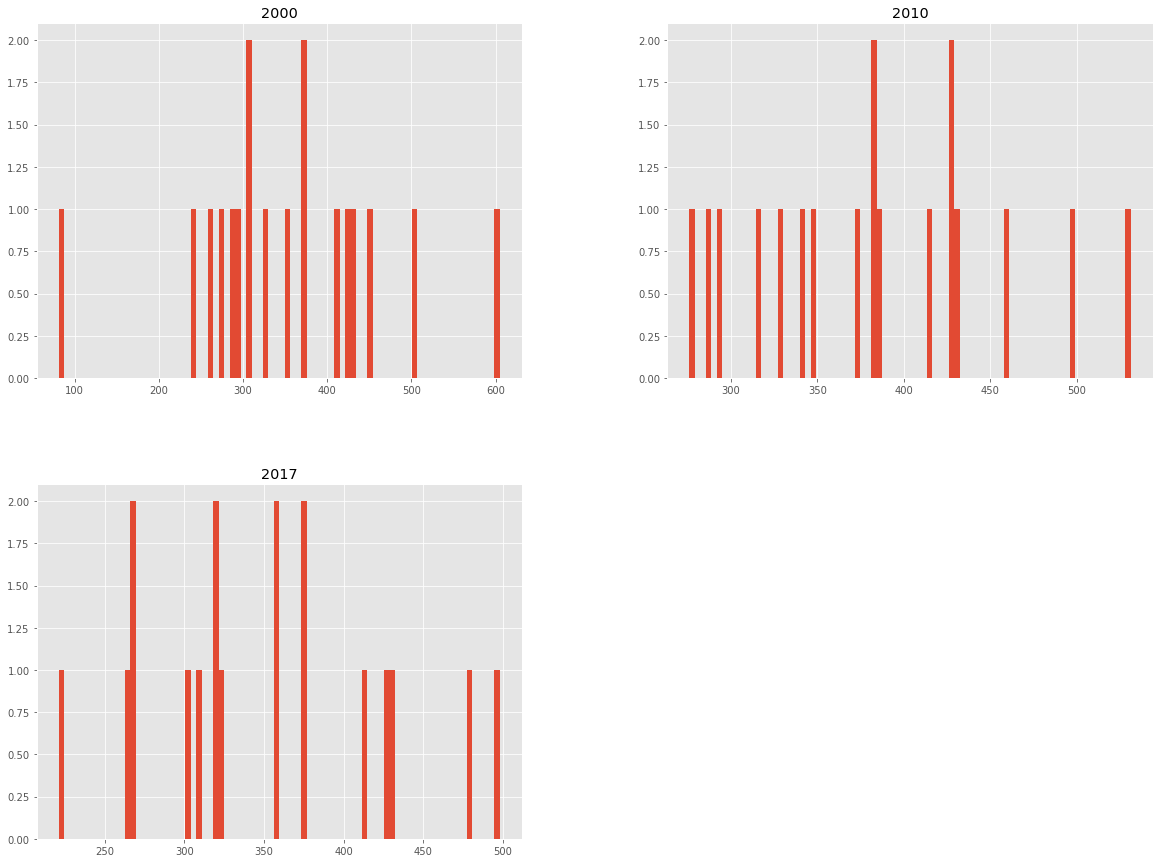

In [55]:
cluster1[["2000","2010","2017"]].hist(bins=80, figsize=(20,15))

### Cluster 2, 3 países

In [37]:
cluster2=datafinal[datafinal["cluster"]==2]
print(cluster2.index)
cluster2.describe()


Index(['Eswatini (Kingdom of)', 'Lesotho', 'South Africa'], dtype='object', name='Country')


,2000,2010,2017,cluster
count,3.000000,3.000000,3.000000,3.0
mean,756.333333,1039.333333,513.333333,2.0
std,210.988941,86.494701,184.451439,0.0
min,585.000000,948.000000,308.000000,2.0
25%,638.500000,999.000000,437.500000,2.0
50%,692.000000,1050.000000,567.000000,2.0
75%,842.000000,1085.000000,616.000000,2.0
max,992.000000,1120.000000,665.000000,2.0


In [56]:
cluster2

,2000,2010,2017,cluster
Country,,,,
Eswatini (Kingdom of),692.0,1050.0,308.0,2.0
Lesotho,992.0,1120.0,665.0,2.0
South Africa,585.0,948.0,567.0,2.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224F1C2AE88>,
      dtype=object)

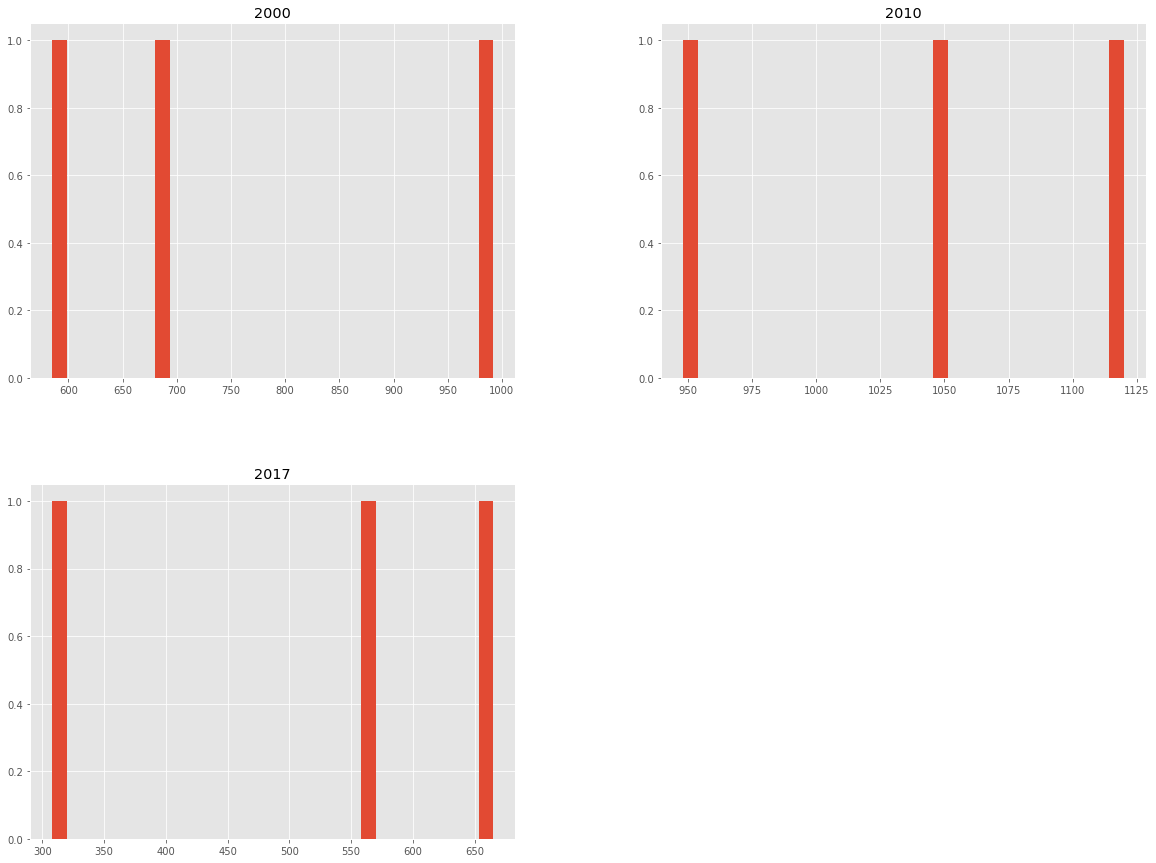

In [60]:
cluster2[["2000","2010","2017"]].hist(bins=30, figsize=(20,15))

#### * En dicho cluster se ubicaron 3 países. Al ser tan poquitos, vale la pena mirar a fondo qué tienes estos 3 países de especial para quedar ubicados en un solo cluster.
#### * Se caracteriza por ser países donde su valor medio de incidencia fue de un nivel muy alto alto. Aun así, su media de incidencia fue demasiado inestable en el paso de los años. Se puede ver como tuvo un elevado crecimiento y posteriormente una grande reducción casi a la mitad. Podría decirse que entre 2010 y 2017, se le trabajó mucho a la salud en estos países, y se logró reducir ese número tan elevado, pero aún no lo saca de la categoría con alta incidencia.  Mientras que entre 2000 y 2010, la tuberculosis fue un problema que creció considerablemente en estos países.

#### * Los valores máximos alcanzados en este cluster son los peores de todos.
#### * En este cluster están los 3 países más maltratados por la tuberculosis: Eswatini, Lesotho, South Africa. Los 3 países son áfricanos. Los histogramas dan fe de ello, pues los valores siempre se concentran en las partes más altas.

### Cluster 3, 10 países

In [40]:
cluster3=datafinal[datafinal["cluster"]==3]
print(cluster3.index)
cluster3.describe()


Index(['Botswana', 'Cambodia', 'Central African Republic', 'Djibouti', 'Gabon',
       'Korea (Democratic People's Rep. of)', 'Mozambique', 'Namibia',
       'Philippines', 'Zambia'],
      dtype='object', name='Country')


,2000,2010,2017,cluster
count,10.000000,10.000000,10.000000,10.0
mean,685.200000,529.000000,424.900000,3.0
std,187.397261,68.639153,107.982972,0.0
min,513.000000,431.000000,269.000000,3.0
25%,530.000000,499.500000,334.750000,3.0
50%,641.000000,524.500000,423.000000,3.0
75%,747.000000,555.500000,525.000000,3.0
max,1070.000000,649.000000,554.000000,3.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224F26427C8>,
      dtype=object)

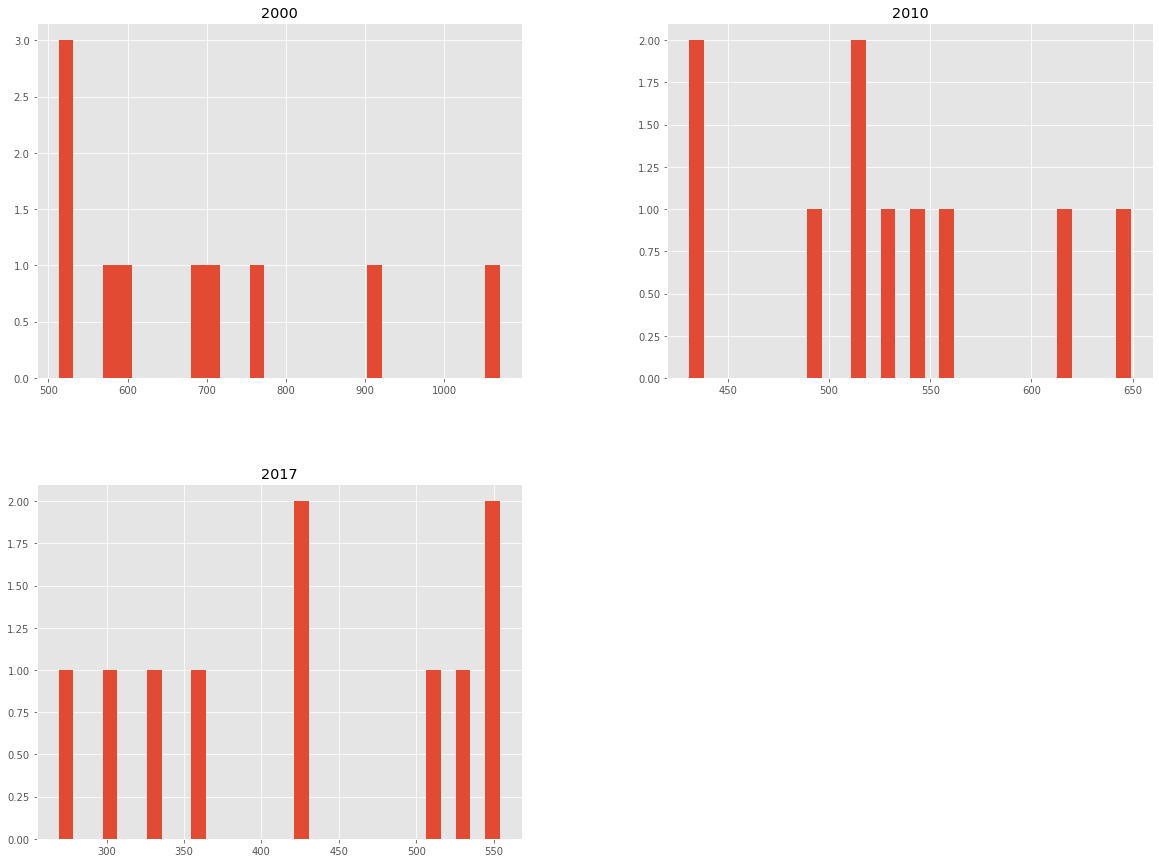

In [61]:
cluster3[["2000","2010","2017"]].hist(bins=30, figsize=(20,15))

#### * En dicho cluster se ubicaron 10 países.
#### * Se caracteriza por ser países donde su valor medio de incidencia fue demasiado elevado, pero disminuyó con el tiempo. Podría decirse que son países con afectación alta, pero no extrema como se observó en otro cluster.
#### * Los valores máximos alcanzados en este cluster están cerca de los peores de todos.
#### * En este cluster están mayormente países Áfricanos y algunos países asiáticos.
#### * El histograma muestra como el problema de la incidencia se fue tratando con el paso del tiempo

### Cluster 4, 36 países

In [42]:
cluster4=datafinal[datafinal["cluster"]==4]
print(cluster4.index)
cluster4.describe()


Index(['Afghanistan', 'Bangladesh', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Burundi', 'Cabo Verde', 'Cameroon',
       'Chad', 'Côte d'Ivoire', 'Equatorial Guinea', 'Eritrea', 'Ethiopia',
       'Gambia', 'Georgia', 'Ghana', 'Guinea', 'Haiti', 'India', 'Kazakhstan',
       'Kyrgyzstan', 'Lao People's Democratic Republic', 'Madagascar',
       'Malawi', 'Mauritania', 'Micronesia (Federated States of)', 'Nepal',
       'Niger', 'Nigeria', 'Peru', 'Sao Tome and Principe', 'Senegal',
       'Tajikistan', 'Thailand', 'Tuvalu', 'Uganda', 'Viet Nam'],
      dtype='object', name='Country')


,2000,2010,2017,cluster
count,36.000000,36.000000,36.000000,36.0
mean,227.833333,179.194444,150.750000,4.0
std,75.437202,51.611637,46.106941,0.0
min,96.000000,108.000000,66.000000,4.0
25%,182.250000,135.750000,117.500000,4.0
50%,219.000000,170.500000,152.000000,4.0
75%,271.500000,219.500000,183.000000,4.0
max,421.000000,332.000000,238.000000,4.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224F32B8588>,
      dtype=object)

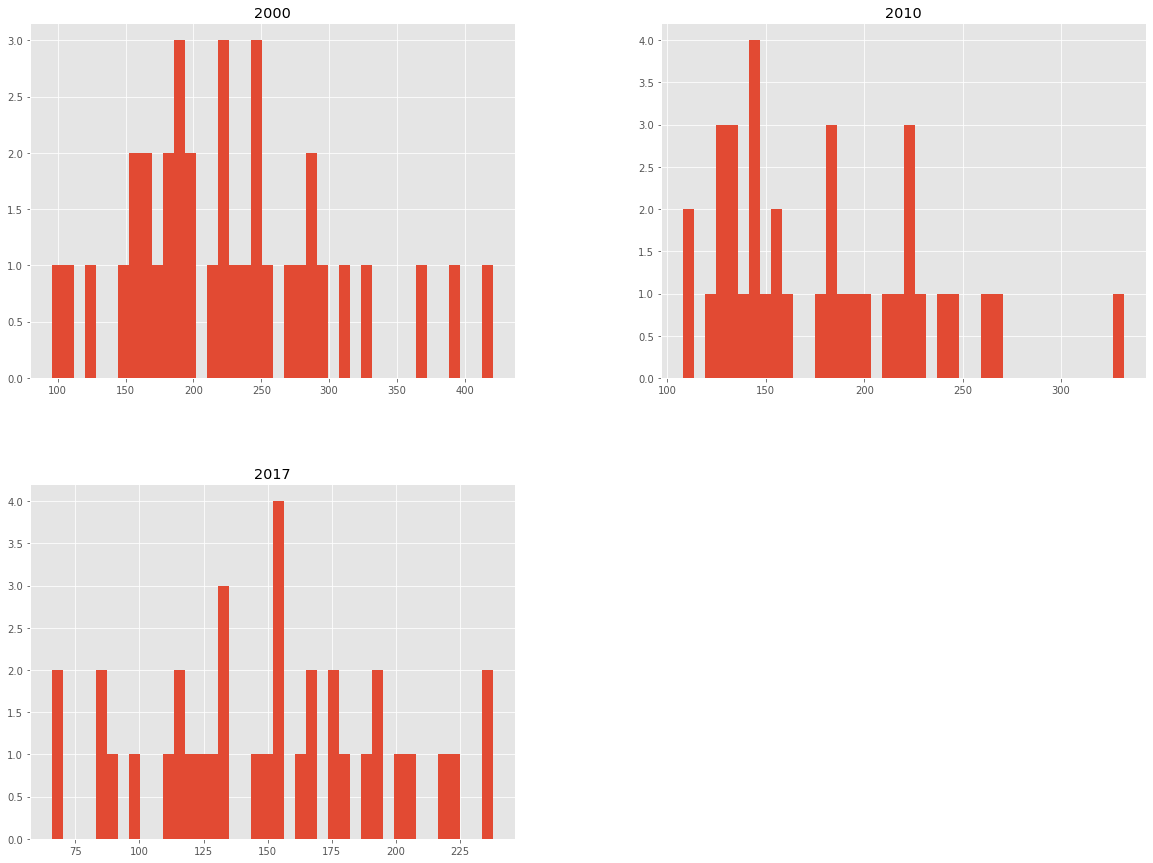

In [63]:
cluster4[["2000","2010","2017"]].hist(bins=40, figsize=(20,15))

#### * En dicho cluster se ubicaron 36 países.
#### *Evidentemente es el segundo cluster con mejores niveles de incidencia en todo el mundo. 
#### *En este cluster están países de todos los continentes, países en vias de desarrollo generalmente. No son países con problemas graves de acceso a salud.
#### *En estos países el problema de la tuberculosis nunca ha sido demasiado fuerte y se ha ido controlando, por lo que ha bajado lentamente con el paso del tiempo
#### * El histograma muestra que los valores se concentran mayormente en la parte medio baja de la escala

### <font color='red'>  <h1>Análisis para América Latina:</h1> <font>


### América Latina en general, quedó en el cluster 0, el cual es el cluster con mejores niveles de indicencias de tuberculosis.

In [68]:
datafinal[193:] ##Ubicación de américa laatina

,2000,2010,2017,cluster
Country,,,,
Latin America and the Caribbean,53.9,42.7,42.3,0.0


### Este resultado podía esperarse, pues en general los países latinoamericanos se ubicaron en este cluster. Se observa el cluster de algunos de los principales países latinoamericanos:

In [78]:
print(datafinal.loc["Colombia"])
print(datafinal.loc["Brazil"])
print(datafinal.loc["Argentina"])
print(datafinal.loc["Chile"])
print(datafinal.loc["Venezuela (Bolivarian Republic of)"])
print(datafinal.loc["Ecuador"])
print(datafinal.loc["Peru"])
print(datafinal.loc["Mexico"])
print(datafinal.loc["Panama"])
print(datafinal.loc["Uruguay"])
print(datafinal.loc["Paraguay"])
print(datafinal.loc["Costa Rica"])
print(datafinal.loc["Guatemala"])
print(datafinal.loc["Nicaragua"])
print(datafinal.loc["Bolivia (Plurinational State of)"])

2000       36.0
2010       31.0
2017       33.0
cluster     0.0
Name: Colombia, dtype: float64
2000       51.0
2010       44.0
2017       44.0
cluster     0.0
Name: Brazil, dtype: float64
2000       37.0
2010       20.0
2017       26.0
cluster     0.0
Name: Argentina, dtype: float64
2000       23.0
2010       16.0
2017       17.0
cluster     0.0
Name: Chile, dtype: float64
2000       33.0
2010       28.0
2017       42.0
cluster     0.0
Name: Venezuela (Bolivarian Republic of), dtype: float64
2000       68.0
2010       40.0
2017       43.0
cluster     0.0
Name: Ecuador, dtype: float64
2000       186.0
2010       132.0
2017       116.0
cluster      4.0
Name: Peru, dtype: float64
2000       23.0
2010       21.0
2017       22.0
cluster     0.0
Name: Mexico, dtype: float64
2000       48.0
2010       53.0
2017       54.0
cluster     0.0
Name: Panama, dtype: float64
2000       22.0
2010       24.0
2017       31.0
cluster     0.0
Name: Uruguay, dtype: float64
2000       42.0
2010       42.0
20

### Se confirma que la gran parte de los países está en dicho cluster, por eso américa latina en general se ubica allí. Esto habla muy bien de la región, pues significa que los países en general tienen buen acceso a salud y la incidencia de tuberculosis es muy baja.

####  <font color='red'>  <h1> ¿Qué países tienen los peores índices y en cual clúster quedaron? (cite un país en cada continente).</h1> <font>
    
### *  Como se pudo ver en la caracterización de cada cluster, los países del continente africano fueron los de peor indice, incluso en el cluster con los índices más malos, que fue de 3 países, todos pertenecen a dicho continente: Eswatini, Lesotho, South Africa

### * Por el lado del continente américano, los índices más bajos los registraron Perú, Haiti, Bolivia, todos en el cluster 4.

In [87]:
print(cluster4.loc["Bolivia (Plurinational State of)"])
print(cluster4.loc["Haiti"])
print(cluster4.loc["Peru"])

2000       184.0
2010       135.0
2017       111.0
cluster      4.0
Name: Bolivia (Plurinational State of), dtype: float64
2000       270.0
2010       229.0
2017       181.0
cluster      4.0
Name: Haiti, dtype: float64
2000       186.0
2010       132.0
2017       116.0
cluster      4.0
Name: Peru, dtype: float64


### De los países europeos, el de peores índices fue Georgia, curiosamente es el único país Europeo que quedó ubicado en cluster 4. 

In [93]:
cluster4.loc["Georgia"]

2000       254.0
2010       127.0
2017        86.0
cluster      4.0
Name: Georgia, dtype: float64

### De los países Asiáticos, los peores indíces los tuvieron los países ubicados en el cluster número 3, el cul tiene países que han sido bastante afectados por la tuberculosis. 


In [95]:
print(cluster3.loc["Cambodia"])
print(cluster3.loc["Korea (Democratic People's Rep. of)"])
print(cluster3.loc["Philippines"])

2000       575.0
2010       436.0
2017       326.0
cluster      3.0
Name: Cambodia, dtype: float64
2000       513.0
2010       513.0
2017       513.0
cluster      3.0
Name: Korea (Democratic People's Rep. of), dtype: float64
2000       590.0
2010       531.0
2017       554.0
cluster      3.0
Name: Philippines, dtype: float64


### De los países de Oceanía, todos quedaron en general muy bien ubicados, la mayoría en el cluster 1. Los peores fueron algunos que quedaron en el cluster 4: Tuvalu y Micronesia

In [152]:
print(cluster4.loc["Tuvalu"])
print(cluster4.loc["Micronesia (Federated States of)"])

2000       195.0
2010       153.0
2017       236.0
cluster      4.0
Name: Tuvalu, dtype: float64
2000       106.0
2010       198.0
2017       165.0
cluster      4.0
Name: Micronesia (Federated States of), dtype: float64


In [108]:
datapintar=datafinal[0:-1].copy()
datapintar.to_csv(r'C:\Users\Gonza\Desktop\Noveno semestre\IA\datos.csv')

### De acá para abajo se muestra un procesamiento que se hizo para usando el lenguaje R, pintar un mapa de clusters a nivel mundial. Se prepararon unos archivos que posteriormente fueron leidos en R, donde se tenía el conocimiento para hacer la gráfica. Se adjunta el resultado al final.

In [156]:
##Abrir indice de países:
paises=pd.read_csv("lista.csv",encoding = "ISO-8859-1")

datafinal
copia=datafinal.copy()

copia=copia.reset_index()
copia.head()

#paises.head()

,Country,2000,2010,2017,cluster
0,Afghanistan,190.0,189.0,189.0,4.0
1,Albania,22.0,17.0,20.0,0.0
2,Algeria,74.0,77.0,70.0,0.0
3,Andorra,21.0,9.5,1.5,0.0
4,Angola,297.0,384.0,359.0,1.0


In [157]:
for i in range (0,len(copia)):
    paisoriginal=str(copia.loc[i]["Country"])
    if paisoriginal=="Russian Federation":
        copia.at[i,"Country"]="Russia"
    elif paisoriginal=="Iran (Islamic Republic of)":
        copia.at[i,"Country"]="Iran"
    elif paisoriginal=="Afghanistan":
        copia.at[i,"Country"]="Afghamistan"
    elif paisoriginal=="Sudan":
        copia.at[i,"Country"]="Sudan"
    elif paisoriginal=="Côte d'Ivoire":
        copia.at[i,"Country"]="Ivory Coast"
        
    
    else:
        
        paisoriginal=copia.loc[i]["Country"].lower()
        paisoriginal=paisoriginal.replace(" ","")
        
        for j in range(0,len(paises)):
            try:
                
                paisexterno=str(paises.loc[j]["COUNTRY"])
                paisexterno=paises.loc[j]["COUNTRY"].lower()
                paisexterno=paises.loc[j]["COUNTRY"].replace(" ","")
                contador=0
                for letra in range(0,len(paisexterno)):
                    try:
                        if paisexterno[letra]==paisoriginal[letra]:
                            contador+=1
                    except:
                        break
                if (contador/len(paisexterno)>0.85):
                    print("YES",paisexterno,paisoriginal)
                    copia.at[i,"Country"]=str(paises.loc[j]["COUNTRY"])
            except:
                pass
            

YES Albania albania
YES Algeria algeria
YES Andorra andorra
YES Argentina argentina
YES Armenia armenia
YES Australia australia
YES Austria austria
YES Azerbaijan azerbaijan
YES Bangladesh bangladesh
YES Barbados barbados
YES Belarus belarus
YES Belgium belgium
YES Bolivia bolivia(plurinationalstateof)
YES Botswana botswana
YES Burundi burundi
YES Cambodia cambodia
YES Cameroon cameroon
YES CentralAfricanRepublic centralafricanrepublic
YES Colombia colombia
YES Comoros comoros
YES Croatia croatia
YES Denmark denmark
YES Djibouti djibouti
YES Dominica dominica
YES Dominica dominicanrepublic
YES DominicanRepublic dominicanrepublic
YES Ecuador ecuador
YES EquatorialGuinea equatorialguinea
YES Eritrea eritrea
YES Estonia estonia
YES Ethiopia ethiopia
YES Finland finland
YES Georgia georgia
YES Germany germany
YES Grenada grenada
YES Guatemala guatemala
YES Honduras honduras
YES Hungary hungary
YES Iceland iceland
YES Indonesia indonesia
YES Ireland ireland
YES Jamaica jamaica
YES Kazakhsta

In [158]:
copiafinal=copia[0:-1]
copiafinal.to_csv(r'C:\Users\Gonza\Desktop\Noveno semestre\IA\datosFINAL.csv')


## Gráfico del mapa mundial según cada cluster:

### * Cluster 0 -> Amarillo
### * Cluster 1 -> Rojo
### * Cluster 2 -> Azul
### * Cluster 3 ->Negro
### * Cluster 4 -> Verde



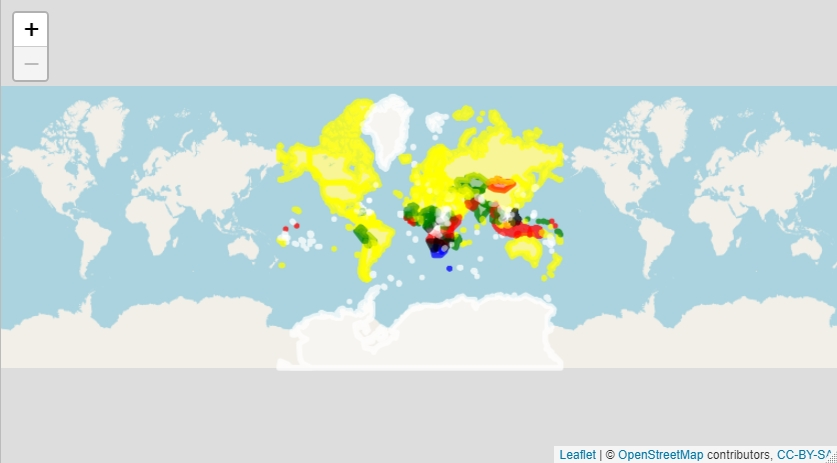

In [162]:
from IPython.display import Image
from IPython.core.display import HTML 
#Image(url= "http://my_site.com/my_picture.jpg")
Image(filename ="CLUSTERFINAL.jpeg", width=1000, height=1000)